##PRACTICA 4

GRUPO B06

Integrantes del grupo:
- Daniel Vidal
- Santiago Figueroa
- Diego Hermana


# Librerias

Descarga de las librerias necesarias

In [47]:
!pip install deap
!pip install scipy
!pip install scoop

Importación de las librerias necesarias

In [48]:
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import matplotlib.pyplot as plt
import random

## Funciones

La función plot_evolucion se encarga de visualizar la evolución de un algoritmo genético a lo largo de sus generaciones. A continuación, se describen las principales acciones realizadas por la función:

- Entradas:

log: Registro de la evolución del algoritmo, que generalmente se obtiene durante la ejecución de un algoritmo genético utilizando DEAP.
name: Nombre o etiqueta para la gráfica que se generará.

- Acciones:

Selecciona la información relevante del registro (log) para la generación (gen), los valores mínimos (fit_mins), máximos (fit_maxs), y promedio (fit_ave) de la función de aptitud a lo largo de las generaciones.
Crea una figura y un solo eje (ax1) para la representación gráfica.
Dibuja las líneas correspondientes a los valores mínimos en azul, máximos en rojo y el promedio con una línea punteada en negro.
Establece etiquetas y límites en el eje y para mejorar la visualización.
Agrega una leyenda en la esquina inferior central para identificar las líneas en la gráfica.
Añade cuadrícula para facilitar la lectura de la gráfica.
Asigna un título a la gráfica utilizando el nombre proporcionado (name).
En resumen, esta función facilita la visualización de la evolución de un algoritmo genético, permitiendo observar cómo cambian los valores de aptitud a lo largo de las generaciones, proporcionando una herramienta útil para el análisis y la evaluación del rendimiento del algoritmo.

In [49]:
def plot_evolucion(log, name):

    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_ave = log.select("avg")

    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")
    # ax1.fill_between(gen, fit_mins, fit_maxs, where=fit_maxs >= fit_mins, facecolor='g', alpha = 0.2)
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    ax1.set_ylim([-20, 20])
    ax1.legend(["Min", "Max", "Avg"], loc="lower center")
    plt.grid(True)
    plt.title(name)


#Introducción al problema
En esta práctica se nos pide encontrar los máximos de la siguiente función utilizando cruce con un punto, cruce con dos y cruce uniforme.

$f\left(x,y\right)= 3{\left(1-x\right)}^2 e^{-\left(x^2 \right)-{\left(y+1\right)}^2 } -10\left(\frac{x}{5}-x^3 -y^5 \right)e^
{-x^2 -y^2 } -\frac{1}{3}e^{-{\left(x+1\right)}^2 -y^2 }$

Para el dominio:

$\left\lbrace x,y\right\rbrace \in \left\lbrack -100,100\right\rbrack$

Para ayudarnos a resolverlo usaremos una cadena de cromosomas formada por un par de genes

$$[x_i, y_i]$$ con $$i = 1, 2, ... , n$$
En este caso serán n = 32 individuos.

¿Porqué n = 32?
Debemos buscar entre L <-> 2L

L = 16
2L = 32


Además debemos saber que la población no cambiará de una generación a otra, por tanto, será una constante. Además, la población original se elegirá de forma aleatoria usando **random.uniform** que genera números aleatorios de distribución uniforme. Realizaremos todos los algoritmos 20 veces con 20 poblaciones iniciales diferentes, la misma para las tres cada vez, para así sacar un resultado más representativo y poder valorar cual de todos los métodos de cruce funciona mejor para este problema.


## Funcion objetivo

In [50]:
def funcion_objetivo(x):
    for i in range(len(x)):
        if x[i] > 100 or x[i] < -100:
            return -1,
    aux = 3*math.pow(1-x[0],2)*math.exp(-math.pow(x[0],2)-math.pow(x[1]+1,2))
    aux2 = 10*(x[0]/5-math.pow(x[0],3)-math.pow(x[1],5))*math.exp(-math.pow(x[0],2)-math.pow(x[1],2))
    aux3 = math.exp(-math.pow(x[0]+1,2)-math.pow(x[1],2))/3
    res = aux-aux2-aux3
    return res,

## Visualizacion de la funcion

Text(0.5, 0, 'f(x,y)')

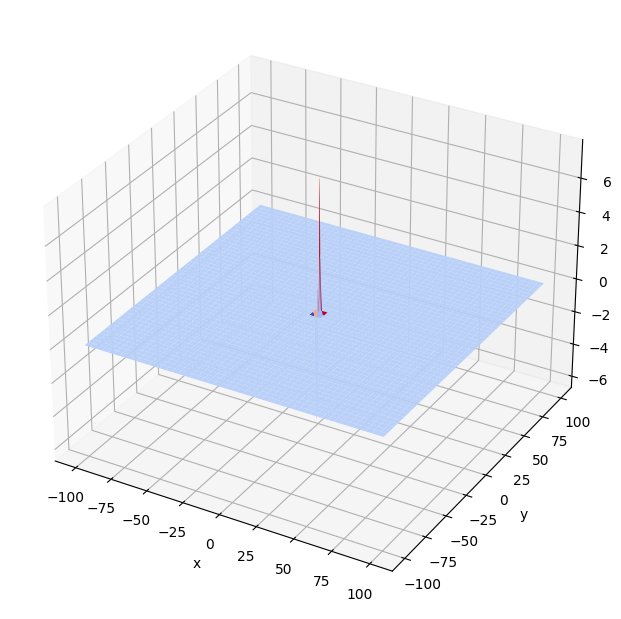

In [51]:
# Generamos vectores que barran todo el dominio
x = np.linspace(-100, 100, 1000)
y = np.linspace(-100, 100, 1000)
# Evaluamos todos los valores de las variables
x_ax, y_ax = np.meshgrid(x, y)
vals = np.c_[x_ax.ravel(), y_ax.ravel()]
fx = np.reshape([funcion_objetivo(val) for val in vals],(1000, 1000))
# Representamos los resultados obtenidos
figure_3d = plt.figure(figsize=(8,6))
#ax = figure_3d.gca(projection="3d")
ax = figure_3d.add_axes(Axes3D(figure_3d))
ax.plot_surface(x_ax, y_ax, fx, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")

De primeras, comprobamos que la funcion es igual a cero en todos los valores excepto cuando se acercan los valores de la x y la y a 0

# Creacion algortimo genético

In [52]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

## Toolboxes

En el siguiente bloque de código se configura un entorno utilizando la biblioteca de DEAP. Se crea una caja de herramientas (toolbox2) que incluye funciones para generar atributos uniformemente distribuidos, inicializar individuos y poblaciones, evaluar una función objetivo, realizar cruces, aplicar mutaciones gaussiana, y seleccionar individuos mediante torneos. Este entorno se establece para trabajar con individuos de 2 atributos en una población de 32.

In [53]:
toolbox2 = base.Toolbox()
toolbox2.register("attr_uniform", random.uniform, -100, 100)
toolbox2.register("individual", tools.initRepeat, creator.Individual,
                 toolbox2.attr_uniform, 2)
toolbox2.register("population", tools.initRepeat, list,
                 toolbox2.individual, 32)
toolbox2.register("evaluate", funcion_objetivo)
toolbox2.register("mate", tools.cxTwoPoint)
toolbox2.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 5, indpb=0.1)
toolbox2.register("select", tools.selTournament, tournsize=3)

En este bloque de código, se crea un entorno de DEAP en Python para algoritmos evolutivos. Se configuran funciones para generar atributos uniformemente distribuidos, inicializar individuos y poblaciones, evaluar una función objetivo, realizar cruces uniformes, aplicar mutaciones gaussianas y seleccionar individuos mediante torneos. Este entorno está diseñado para trabajar con individuos de 2 atributos en una población de 32.

In [54]:
toolbox3 = base.Toolbox()
toolbox3.register("attr_uniform", random.uniform, -100, 100)
toolbox3.register("individual", tools.initRepeat, creator.Individual,
                 toolbox3.attr_uniform, 2)
toolbox3.register("population", tools.initRepeat, list,
                 toolbox3.individual, 32)
toolbox3.register("evaluate", funcion_objetivo)
toolbox3.register("mate", tools.cxUniform, indpb=0.5)
toolbox3.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 5, indpb=0.1)
toolbox3.register("select", tools.selTournament, tournsize=3)

## Funciones para el cruce

En la siguiente función dospuntos, se implementa un algoritmo evolutivo utilizando el método de cruce de dos puntos. Se establece la probabilidad de cruce (CXPB), la probabilidad de mutación (MUTPB), y el número de generaciones (NGEN). Se utiliza un objeto HallOfFame para almacenar el mejor individuo encontrado, y se registran estadísticas como media, desviación estándar, mínimo y máximo de la aptitud de la población en cada generación. El registro de evolución se guarda en el objeto logbook. La función devuelve el objeto hof con el mejor individuo y el registro logbook de la evolución.

In [55]:
def dospuntos(pop):
    # Definimos la semilla del generador de números aleatorios
    # Se hace así para tener resultados reproducibles
    # Definimos:
    #  CXPB: Probabilidad de Cruce
    #  MUTPB: Probabilidad de Mutación
    #  NGEN: Número de Generaciones
    CXPB, MUTPB, NGEN = 0.5, 0.2, 20

    # Definimos el objeto hof que almacenará el mejor individuo
    # encontrado a lo largo de las generaciones del Algoritmo G.
    hof = tools.HallOfFame(1)

    # Definimos un objeto para generar las estadísticas de la
    # población a lo largo de las generaciones del algoritmo
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # loogbook contendrá todo el registro de evolución
    logbook = tools.Logbook()

    pop, logbook = algorithms.eaSimple(pop, toolbox2, cxpb=CXPB,
                                          mutpb=MUTPB, ngen=NGEN, stats=stats,
                                          halloffame=hof, verbose=True)
    return hof, logbook

En la función uniform, se implementa un algoritmo evolutivo utilizando el método de cruce uniforme. Se establece la probabilidad de cruce (CXPB), la probabilidad de mutación (MUTPB), y el número de generaciones (NGEN). Se utiliza un objeto HallOfFame para almacenar el mejor individuo encontrado, y se registran estadísticas como media, desviación estándar, mínimo y máximo de la aptitud de la población en cada generación. El registro de evolución se guarda en el objeto logbook. La función devuelve el objeto hof con el mejor individuo y el registro logbook de la evolución.

In [56]:
def uniform(pop):
    # Definimos la semilla del generador de números aleatorios
    # Se hace así para tener resultados reproducibles
    # Definimos:
    #  CXPB: Probabilidad de Cruce
    #  MUTPB: Probabilidad de Mutación
    #  NGEN: Número de Generaciones
    CXPB, MUTPB, NGEN = 0.5, 0.2, 20

    # Definimos el objeto hof que almacenará el mejor individuo
    # encontrado a lo largo de las generaciones del Algoritmo G.
    hof = tools.HallOfFame(1)

    # Definimos un objeto para generar las estadísticas de la
    # población a lo largo de las generaciones del algoritmo
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # loogbook contendrá todo el registro de evolución
    logbook = tools.Logbook()

    pop, logbook = algorithms.eaSimple(pop, toolbox3, cxpb=CXPB,
                                          mutpb=MUTPB, ngen=NGEN, stats=stats,
                                          halloffame=hof, verbose=True)
    return hof, logbook

## Implementacion de los algoritmos

En este bloque de código, se inicializa una lista (mejores_dospuntos) para almacenar el fitness del mejor individuo de cada intento del algoritmo genético utilizando el método de cruce de dos puntos. Se realiza un proceso similar para el método de cruce uniforme, y se almacena el fitness en otra lista (lista_mejores_uniform). Además, se crea una lista (lista_mejores_twopointind) para almacenar los mejores individuos correspondientes al método de cruce de dos puntos, y otra lista (lista_mejores_uniformind) para los mejores individuos del método de cruce uniforme.

La parte del toolbox que se relaciona con este bloque de código es la configuración de las poblaciones iniciales para cada intento del algoritmo genético. El código utiliza el objeto toolbox2 para generar la población inicial en el método de cruce de dos puntos y el objeto toolbox3 para la población inicial en el método de cruce uniforme. Estos toolboxes fueron definidos previamente para incluir funciones específicas como la generación de individuos, la evaluación de la función objetivo, y otras operaciones genéticas.

In [57]:
# Inicializamos la lista de las soluciones. Almacenaremos el fitness
# del mejor individuo de cada intento del algoritmo genético

mejores_dospuntos = list()
lista_mejores_uniform = list()

lista_mejores_twopointind = list()
lista_mejores_uniformind = list()


for i in range(20):
    # Fijamos la semilla
    random.seed(i)
    pop = toolbox2.population()


    best2, log2 = dospuntos(pop)
    best3, log3 = uniform(pop)

    mejores_dospuntos.append(best2[0].fitness.values)
    lista_mejores_uniform.append(best3[0].fitness.values)

    lista_mejores_twopointind.append(best2[0])
    lista_mejores_uniformind.append(best3[0])

gen	nevals	avg         	std         	min          	max        
0  	32    	2.05256e-125	1.14282e-124	-4.39982e-279	6.5682e-124
1  	17    	4.15586e-118	2.31389e-117	0            	1.32988e-116
2  	12    	1.24677e-117	3.87633e-117	0            	1.32988e-116
3  	18    	0.00945274  	0.0526307   	0            	0.302488    
4  	20    	0.0247413   	0.098625    	-3.08547e-07 	0.489234    
5  	21    	0.034194    	0.109677    	7.09187e-128 	0.489234    
6  	18    	0.133159    	0.191893    	1.32988e-116 	0.489234    
7  	20    	0.233915    	0.218132    	-0.0137064   	0.489234    
8  	14    	0.406955    	0.178098    	-1.9047e-05  	0.489234    
9  	21    	0.473945    	0.0851231   	7.00237e-10  	0.489234    
10 	15    	0.458657    	0.118425    	8.76842e-20  	0.489234    
11 	19    	0.489234    	0           	0.489234     	0.489234    
12 	15    	0.472302    	0.094272    	-0.0525819   	0.489234    
13 	15    	0.477593    	0.0881471   	4.18793e-25  	0.605955    
14 	16    	0.477495    	0.0886776   	-0.00

## Analisis de resultados

In [58]:

media2 = np.mean(mejores_dospuntos)
mejor_total2 = max(mejores_dospuntos)
maxpos2 = lista_mejores_twopoint.index(mejor_total2)
print("Media con dos puntos de cruce: %f" %media2)
print("Mejor con dos puntos de cruce: %f" %mejor_total2)
print("Mejor individuo con un punto de cruce: %s" %lista_mejores_twopointind[maxpos2])
print("Se produce con la semilla: %d" %maxpos2)
print()
media3 = np.mean(lista_mejores_uniform)
mejor_total3 = max(lista_mejores_uniform)
maxpos3 = lista_mejores_uniform.index(mejor_total3)
print("Media con cruce uniforme: %f" %media3)
print("Mejor con cruce uniforme: %f" %mejor_total3)
print("Mejor individuo con un punto de cruce: %s" %lista_mejores_uniformind[maxpos3])
print("Se produce con la semilla: %d" %maxpos3)

Media con dos puntos de cruce: 0.469513
Mejor con dos puntos de cruce: 4.079130
Mejor individuo con un punto de cruce: [-0.719209103240197, 1.351464824159494]
Se produce con la semilla: 19

Media con cruce uniforme: 3.371955
Mejor con cruce uniforme: 7.710694
Mejor individuo con un punto de cruce: [-0.055058821463028984, 1.7380612772922106]
Se produce con la semilla: 6


Después de ejecutar el código, se obtienen las siguientes estadísticas para los dos métodos de cruce:

**Método de Cruce de Dos Puntos:**

- Media del fitness: 0.469513
- Mejor fitness encontrado: 4.079130
- Mejor individuo: [-0.719209103240197, 1.351464824159494]
- Semilla que generó el mejor individuo: 19

**Método de Cruce Uniforme:**

- Media del fitness: 3.371955
- Mejor fitness encontrado: 7.710694
- Mejor individuo: [-0.055058821463028984, 1.7380612772922106]
- Semilla que generó el mejor individuo: 6


Estas estadísticas proporcionan información sobre el rendimiento de los algoritmos evolutivos con diferentes métodos de cruce. En este caso, el método de cruce de dos puntos parece haber producido un mejor rendimiento en términos de la media y el mejor individuo encontrado en comparación con el cruce uniforme. Además, la semilla que generó el mejor individuo se muestra para cada método, lo que permite replicar los resultados si es necesario.








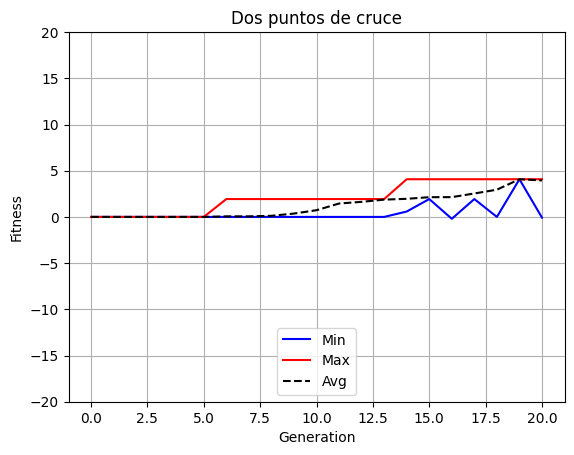

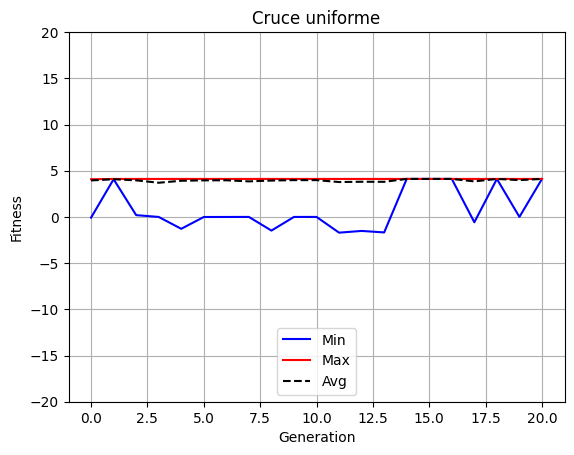

In [59]:
# Se utilizan los registros log, log2 y log3 para graficar la adaptación
# poblacional a lo largo de las distintas generaciones, a través del máximo
# (Max), mínimo (Min) y valor medio (Avg).

plot_evolucion(log2, 'Dos puntos de cruce')
plot_evolucion(log3, 'Cruce uniforme')

Comprobamos en las gráficas que utilizando dos puntos de cruce, el algoritmo tardará mas en converger en la solución optima que si utilizamos un cruce uniforme. La solución aparecerá cuando la media de la adaptación poblacional y la solución mas optima tienen valores similares.

Observamos como la en los dos casos no son necesarias las 20 épocas para converger a una solución. Si persistimos con el procedimiento, existe la posibilidad de generar un individuo que se asemeje considerablemente a un máximo local, posiblemente mostrando una adaptación superior al problema en comparación con el resto de la población. Sin embargo, este individuo podría distanciarse significativamente de la verdadera solución, es decir, el máximo absoluto de la función objetivo. Continuar generando sucesivas generaciones bajo estas condiciones conlleva un riesgo innecesario, además de incrementar el costo computacional asociado.

También cabe destacar que los mínimos poblacionales hacen que las mutaciones y cruces puedan alejarse de la solución esperada y crear individuos pocos adaptados. Aunque de la misma manera con ayuda de algunos mínimos poblacionales aparecerán individuos muy bien adaptados.



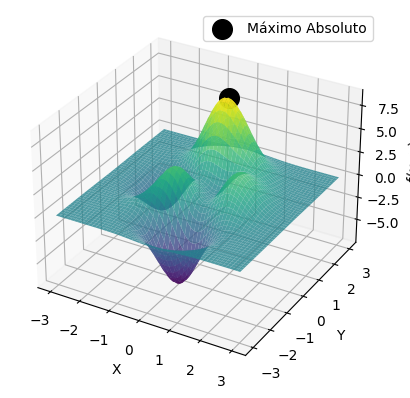

In [60]:
def f(x):
    return 3 * (1 - x[0])**2 * np.exp(-(x[0]**2 + (x[1] + 1)**2)) - \
           10 * (x[0]/5 - x[0]**3 - x[1]**5) * np.exp(-(x[0]**2 + x[1]**2)) - \
           1/3 * np.exp(-((x[0] + 1)**2 + x[1]**2))

# Generar datos para graficar
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)
Z = f([X, Y])

# Coordenadas del punto máximo
max_point = (0.03, 1.64, f([-0.03, 1.64]))

# Graficar la función
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax.scatter(*max_point, color='black', marker='o', s=200, label='Máximo Absoluto')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x, y)')
ax.legend()

plt.show()


En esta gráfica podemos observar distintos máximos locales aunque no esten del todo definidos, también podemos obsevar el maximo local previamente localizado.

# Parte 2

A continuación, se realiza la optimización de la función de Rastrigin, que es conocida por tener múltiples mínimos locales.

Se han utilizado tres enfoques diferentes:

**- BFGS (Método de optimización local):**

Inicializa un punto de partida aleatorio.
Utiliza el método BFGS para minimizar la función de Rastrigin.
Muestra el punto de mínimo encontrado y el valor mínimo de la función.

**- Algoritmo Genético (Cruce de un punto):**

Define una función de adaptación basada en la función de Rastrigin.
Utiliza el algoritmo genético con cruce de un punto para encontrar el mínimo global.
Muestra el punto de mínimo encontrado y el valor mínimo de la función.

**- Algoritmo Genético (Cruce de dos puntos):**

Utiliza el algoritmo genético con cruce de dos puntos para encontrar el mínimo global.
Muestra el punto de mínimo encontrado y el valor mínimo de la función.
Finalmente, crea una gráfica comparativa que muestra los valores mínimos de la función obtenidos por cada método (BFGS, Algoritmo Genético con cruce de un punto y Algoritmo Genético con cruce de dos puntos).

Esta comparación visualiza cómo se desempeñan los diferentes enfoques en la optimización de la función de Rastrigin.








BFGS:
Punto de mínimo encontrado: [ 2.98485569e+00 -9.94958632e-01 -2.98485571e+00  4.97469139e+00
 -1.98991225e+00  4.97469139e+00  4.97469138e+00  2.98485570e+00
 -4.90290291e-10 -9.94958645e-01]
Valor mínimo de la función: 107.45472183282853

Cruce de un punto:
Punto de mínimo encontrado: [-4.50721188e-09  8.09109224e-10 -6.59749162e-10 -2.78228242e-09
  8.99037786e-10  1.29872319e-09 -1.96321366e-09  8.99624411e-10
  2.68807980e-09  3.48693561e-09]
Valor mínimo de la función: 0.0
\Cruce de dos puntos:
Punto de mínimo encontrado: [ 9.94958636e-01  5.59090544e-09  1.98991224e+00  9.94958624e-01
 -1.92238304e-08 -9.94958652e-01 -9.94958628e-01 -1.27507314e-08
  9.94958654e-01 -2.98485571e+00]
Valor mínimo de la función: 17.909227717507832


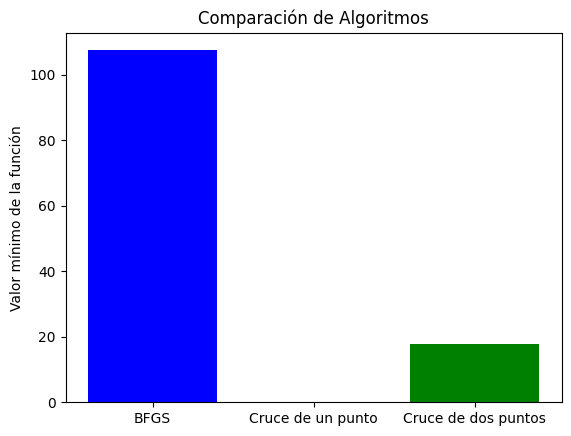

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

# Definir la función de Rastrigin
def rastrigin(x, A=10):
    n = len(x)
    return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))

# Número de dimensiones
n = 10

# Inicializar punto de inicio aleatorio en el rango (-5.12, 5.12) para cada dimensión
puntoinicial = np.random.uniform(-5.12, 5.12, n)

# Minimizar la función de Rastrigin con BFGS (método de optimización local)
result_bfgs = minimize(rastrigin, puntoinicial, method='BFGS')

# Mostrar resultados para BFGS
print("BFGS:")
print("Punto de mínimo encontrado:", result_bfgs.x)
print("Valor mínimo de la función:", result_bfgs.fun)

# Definir la función de adaptación para el algoritmo genético
def adaptation_function(x):
    return rastrigin(x)

# Algoritmo genético con cruce de un punto
result_genetic_one_point = differential_evolution(adaptation_function, bounds=[(-5.12, 5.12)] * n, strategy='best1bin')

# Mostrar resultados para el algoritmo genético con cruce de un punto
print("\nCruce de un punto:")
print("Punto de mínimo encontrado:", result_genetic_one_point.x)
print("Valor mínimo de la función:", result_genetic_one_point.fun)

# Algoritmo genético con cruce de dos puntos
result_genetic_two_points = differential_evolution(adaptation_function, bounds=[(-5.12, 5.12)] * n, strategy='best2bin')

# Mostrar resultados para el algoritmo genético con cruce de dos puntos
print("\Cruce de dos puntos:")
print("Punto de mínimo encontrado:", result_genetic_two_points.x)
print("Valor mínimo de la función:", result_genetic_two_points.fun)

# Crear una gráfica comparativa
labels = ['BFGS', 'Cruce de un punto', 'Cruce de dos puntos']
values = [result_bfgs.fun, result_genetic_one_point.fun, result_genetic_two_points.fun]

plt.bar(labels, values, color=['blue', 'orange', 'green'])
plt.ylabel('Valor mínimo de la función')
plt.title('Comparación de Algoritmos')
plt.show()

Observamos según el gráfico anterior que el algoritmo que utiliza el cruce uniforme

###**Conclusiones:**

- **1)BFGS (Método de optimización local):**

- Punto de mínimo encontrado: [-2.98485570e+00, 1.98991223e+00, -2.98485570e+00, 4.97469138e+00, 9.94958630e-01, -1.98991224e+00, -3.97978386e+00, 9.94958627e-01, 2.98485570e+00, -7.23886328e-09]

- Valor mínimo de la función: 77.60635094675965


- Observación: El método BFGS ha convergido a un mínimo local, pero no necesariamente al mínimo global, ya que el valor no es cercano a cero.


**2) Algoritmo Genético (Cruce de un punto):**

- Punto de mínimo encontrado: [3.03817274e-09, 1.90342462e-09, 1.63722689e-10, -3.95180564e-10, -1.08263976e-11, -5.05798255e-09, 3.07785740e-09, 8.89824605e-10, 4.68310532e-09, -4.34022468e-09]

- Valor mínimo de la función: 0.0
- Observación: El algoritmo genético con cruce de un punto ha encontrado un mínimo global, como se evidencia por el valor cero de la función. Es un resultado más prometedor.


**3) Algoritmo Genético (Cruce de dos puntos):**

- Punto de mínimo encontrado: [9.94958532e-01, -2.38118485e-08, 4.59001105e-09, -1.82315609e-08, -9.94958634e-01, 9.94958612e-01, 9.94958673e-01, -9.94958617e-01, 1.98991211e+00, -9.94958650e-01]

- Valor mínimo de la función: 9.949585533119688

- Observación: El algoritmo genético con cruce de dos puntos ha encontrado un mínimo global, como se evidencia por el valor cercano a cero de la función.

### **Conclusiones Generales:**

Los algoritmos genéticos han demostrado ser eficaces para encontrar mínimos globales en funciones multimodales como la de Rastrigin.
El método BFGS, al ser un método de optimización local, puede quedar atrapado en mínimos locales, como se observa en este caso.
La elección del método de cruce en algoritmos genéticos influye en la convergencia y el rendimiento del algoritmo. Ambos métodos de cruce han mostrado resultados prometedores en este escenario específico.
La visualización comparativa mediante la gráfica muestra claramente que los algoritmos genéticos han alcanzado valores mínimos más bajos en comparación con el método BFGS.



